In [1]:
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple
import os
from tensorflow.keras.optimizers import RMSprop

2024-04-11 00:37:27.841009: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-11 00:37:27.888825: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 00:37:27.888856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 00:37:27.892528: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-11 00:37:27.906223: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import fluidsynth

In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [4]:
#import all the file names
filenames = glob.glob(str("MIDI/pop/**/*.mid"))
# filenames = glob.glob(str("/home/jayden/projects/project_lyrics/MIDI/pop/**/*.mid"))
print('Number of files: ', len(filenames))
sample_file = filenames[5]
print(sample_file)
pm = pretty_midi.PrettyMIDI(sample_file)

Number of files:  2898
MIDI/pop/Romantics/GangnamStyle.mid


In [5]:
#악기 종류 찾아내기
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

for num in range(len(pm.instruments)):
    print('All instruments:' , pretty_midi.program_to_instrument_name(pm.instruments[num].program))

Number of instruments: 12
Instrument name: Celesta
All instruments: Celesta
All instruments: Lead 2 (sawtooth)
All instruments: Lead 1 (square)
All instruments: Lead 1 (square)
All instruments: Synth Brass 1
All instruments: Applause
All instruments: String Ensemble 1
All instruments: Rock Organ
All instruments: Melodic Tom
All instruments: Reverse Cymbal
All instruments: Lead 1 (square)
All instruments: Distortion Guitar


In [116]:
#오디오를 30초간 들을수 있는 펑션
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [119]:
sample_file = filenames[4]
print(sample_file)
pm = pretty_midi.PrettyMIDI(sample_file)
print(pm.instruments[0])

display_audio(pm)

MIDI/pop/Yazoo/Smile.mid


AttributeError: 'PrettyMIDI' object has no attribute 'instrument'

In [6]:
def count_instruments(file_list):
    instrument_counts = {}  # Dictionary to store instrument counts for each file
    files_to_delete = []
    
    for file_name in file_list:
        try:
            pm = pretty_midi.PrettyMIDI(file_name)
            file_instrument_counts = {}  # Dictionary to store instrument counts for the current file
            for instrument in pm.instruments:
                instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
                # file_instrument_counts[instrument_name] = file_instrument_counts.get(instrument_name, 0) + 1
                file_instrument_counts[instrument_name] = 1
            
            # Store instrument counts for the current file in the main dictionary
            # instrument_counts[os.path.basename(file_name)] = file_instrument_counts
            instrument_counts[file_name] = file_instrument_counts
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")
            # Add the file to the list of files to delete
            files_to_delete.append(file_name)
        
    # Delete the files with errors
    for file_to_delete in files_to_delete:
        os.remove(file_to_delete)

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame.from_dict(instrument_counts, orient='index')
    
    # Fill missing values with zeros
    df.fillna(0, inplace=True)
    
    return df

instrument_counts_df = count_instruments(filenames)




/home/jayden/miniconda3/envs/aimusic/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [7]:
#in case I want additional index line with number
# instrument_counts_df.reset_index(inplace=True)

In [8]:
# instrument_counts_df.astype('int32')
instrument_counts_df.head()

,Tango Accordion,Electric Bass (finger),Electric Guitar (jazz),Acoustic Guitar (steel),Bright Acoustic Piano,Synth Choir,String Ensemble 1,Acoustic Grand Piano,Electric Grand Piano,Shakuhachi,...,Slap Bass 2,FX 6 (goblins),Orchestra Hit,FX 3 (crystal),Marimba,Dulcimer,Tinkle Bell,Lead 7 (fifths),Koto,Agogo
MIDI/pop/Marcels/IdLoveYouToWantMe.mid,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MIDI/pop/Jann Arden/GoldDustWoman.mid,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MIDI/pop/Gary Wright/AprilinParis.mid,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MIDI/pop/Sam Smith/GardenParty.mid,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MIDI/pop/BBMak/CouldItBeMagic.mid,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
top_instru = instrument_counts_df.sum().nlargest(20)
print(top_instru.index[0])

Acoustic Grand Piano


In [10]:
instrument_counts_df.sum().index

Index(['Tango Accordion', 'Electric Bass (finger)', 'Electric Guitar (jazz)',
       'Acoustic Guitar (steel)', 'Bright Acoustic Piano', 'Synth Choir',
       'String Ensemble 1', 'Acoustic Grand Piano', 'Electric Grand Piano',
       'Shakuhachi',
       ...
       'Slap Bass 2', 'FX 6 (goblins)', 'Orchestra Hit', 'FX 3 (crystal)',
       'Marimba', 'Dulcimer', 'Tinkle Bell', 'Lead 7 (fifths)', 'Koto',
       'Agogo'],
      dtype='object', length=128)

In [11]:
#나중에 인덱스 찾아서 특정 악기 데이터 뽑기위해서 테스트
test = instrument_counts_df.index[instrument_counts_df[top_instru.index[0]] == 1].tolist()
print(test)

['MIDI/pop/Marcels/IdLoveYouToWantMe.mid', 'MIDI/pop/Jann Arden/GoldDustWoman.mid', 'MIDI/pop/Sam Smith/GardenParty.mid', 'MIDI/pop/BBMak/CouldItBeMagic.mid', 'MIDI/pop/Patti LaBelle/BanksOfTheOhio.mid', 'MIDI/pop/Aha/RollingThunder.mid', 'MIDI/pop/Connie Francis/Outsider.mid', 'MIDI/pop/Eve 6/TiredOfBeingSorry.mid', 'MIDI/pop/Gloria Gaynor/GetItRightNextTime.mid', 'MIDI/pop/Roy Orbison/BlesstheBrokenRoad.mid', 'MIDI/pop/Hole/KidsWithGuns.mid', 'MIDI/pop/Sade/Maria.mid', 'MIDI/pop/Simple Plan/BlueBayou.mid', 'MIDI/pop/Falco/DontLetItBringYouDown.mid', 'MIDI/pop/Aaron Carter/OneBetter.mid', 'MIDI/pop/Culture Club/InTheStillOfTheNight.mid', 'MIDI/pop/Dave Clark Five/GirlsJustWannaHaveFun.mid', 'MIDI/pop/Leann Rimes/Firework.mid', 'MIDI/pop/Annie Villeneuve/DontLetItBringYouDown.mid', 'MIDI/pop/Amanda Lear/Faith.mid', 'MIDI/pop/Eurythmics/BlueKentucky.mid', 'MIDI/pop/Marcels/IWantYouToLoveMe.mid', 'MIDI/pop/Lovin Spoonful/HangingByAMoment.mid', 'MIDI/pop/Lovin Spoonful/Simon.mid', 'MIDI/p

In [12]:
# training model requires 3 variables (pitch, step, duration)
# pitch : perceptual quality of the sound as a midi note
# step : time elapsed from previous note or start of the track
# duration : duration of the current note
# 미디 파일에서 음표 추출하는 부분.

# return pd.DataFrame
def midi_to_notes(midi_file: str, instrument_name: str):
  try:
    pm = pretty_midi.PrettyMIDI(midi_file)
    
    # check if the specific instrument exist in the MIDI file
    instrument = None
    for inst in pm.instruments:
      if pretty_midi.program_to_instrument_name(inst.program) == instrument_name:
          instrument = inst
          break
    if instrument is None:
      # pass
      raise ValueError(f"Instrument '{instrument_name}' not found in the MIDI file")
      
      # raise ValueError()

    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
      start = note.start
      end = note.end
      notes['pitch'].append(note.pitch)
      notes['start'].append(start)
      notes['end'].append(end)
      notes['step'].append(start - prev_start)
      notes['duration'].append(end - start)
      prev_start = start
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})
  except Exception as e:
    print(f"Error occurred while processing file {midi_file}: {e}")


In [81]:
def dict_to_midi(
        instrument_notes_dict : dict,
        out_file: str):
    
        combined_pm = pretty_midi.PrettyMIDI()
        for instrument_name, notes_df in instrument_notes_dict.items():
                instrument = pretty_midi.Instrument(
                program=pretty_midi.instrument_name_to_program(
                        instrument_name))
    
        
                prev_start = 0
                for i, note in notes_df.iterrows():
                        start = float(prev_start + note['step'])
                        end = float(start + note['duration'])
                        note = pretty_midi.Note(
                                velocity=100,
                                pitch=int(note['pitch']),
                                start=start,
                                end=end,
                        )
                        instrument.notes.append(note)
                        prev_start = start
                
                combined_pm.instruments.append(instrument)
        combined_pm.write(out_file)
        return combined_pm

In [13]:
#미디 파일 생성

def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 50,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name)) #피아노를 넣으면 피아노가 있는 경우에 그것의 맞는 Pretty midi instrument 숫자를 리턴

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

데이터 생성

In [15]:
# ## get alllllll instruments
# # instrument_counts_df.sum().index

# all_notes_by_instruments = {}  # Dictionary to store notes for each instrument

# # Loop over each instrument entry in top_instru
# for instru_entry in instrument_counts_df.sum().index:
#     all_notes_list = []  # List to store DataFrame objects for each file
#     temp = instrument_counts_df.index[instrument_counts_df[instru_entry] == 1].to_list()
#     for f in temp:
#         notes = midi_to_notes(f, instru_entry)
#         if notes is not None:
#             all_notes_list.append(notes)
#     all_notes_by_instruments[instru_entry] = all_notes_list

# # Concatenate DataFrames separately for each instrument
# all_notes_by_instruments_df = {}
# for instrument_name, notes_list in all_notes_by_instruments.items():
#     all_notes_by_instruments_df[instrument_name] = pd.concat(notes_list, ignore_index=True)

# # access notes for each instrument:
# for instrument_name, notes_df in all_notes_by_instruments_df.items():
#     print(f"Notes for instrument '{instrument_name}':")
#     print(notes_df)

In [16]:
# get top 20 instruments
all_notes_by_instrument = {}  # Dictionary to store notes for each instrument

# Loop over each instrument entry in top_instru
for instru_entry in top_instru.index:
    all_notes_list = []  # List to store DataFrame objects for each file
    temp = instrument_counts_df.index[instrument_counts_df[instru_entry] == 1].to_list()
    for f in temp:
        notes = midi_to_notes(f, instru_entry)
        if notes is not None:
            all_notes_list.append(notes)
    all_notes_by_instrument[instru_entry] = all_notes_list

# Concatenate DataFrames separately for each instrument
all_notes_by_instrument_df = {}
for instrument_name, notes_list in all_notes_by_instrument.items():
    all_notes_by_instrument_df[instrument_name] = pd.concat(notes_list, ignore_index=True)

# access notes for each instrument:
for instrument_name, notes_df in all_notes_by_instrument_df.items():
    print(f"Notes for instrument '{instrument_name}':")
    print(notes_df)

/home/jayden/miniconda3/envs/aimusic/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Notes for instrument 'Acoustic Grand Piano':
         pitch       start         end      step  duration
0           35    3.116884    4.038962  0.000000  0.922078
1           35    4.512988    4.655845  1.396104  0.142857
2           35    4.675326    4.948053  0.162338  0.272727
3           35    5.064936    5.487015  0.389610  0.422078
4           35    5.844157    6.019482  0.779221  0.175325
...        ...         ...         ...       ...       ...
2896782     42  217.607050  217.639543  0.355182  0.032493
2896783     45  217.802437  217.837222  0.195387  0.034785
2896784     45  217.998103  218.035028  0.195666  0.036926
2896785     57  218.004625  218.042045  0.006522  0.037420
2896786     36  218.004625  218.042045  0.000000  0.037420

[2896787 rows x 5 columns]
Notes for instrument 'Electric Bass (finger)':
        pitch       start         end      step  duration
0          34    3.116884    3.701300  0.000000  0.584416
1          34    3.896105    4.396105  0.779221  0.50000

In [17]:
len(all_notes_by_instrument_df)

20

In [120]:
import random

def extract_random_instru_notes(
        midi_files_dict : dict,
        num_samples = 5,
        notes_per_sample = 25
):
    random_samples = {}
    

    for instrument_name, notes in midi_files_dict.items():
        #select sampling points
        temp = []
        start_indices = random.sample(range(len(notes) - notes_per_sample + 1), num_samples)
        
        # Extract 10 continuous samples for each starting point
        for start_index in start_indices:
            end_index = start_index + notes_per_sample
            selected_notes = notes.iloc[start_index:end_index]
            temp.append(selected_notes)


        random_samples[instrument_name] = temp
    
    random_samples_df = {}
    for instrument_name, notes_list in random_samples.items():
        random_samples_df[instrument_name] = pd.concat(notes_list, ignore_index=True)

    return random_samples_df #return dic containing instrument name & 100 random notes.
    

In [113]:
num_samples = 5
notes_per_sample = 25

random_notes = extract_random_instru_notes(all_notes_by_instrument_df, num_samples, notes_per_sample)

In [114]:
random_notes

{'Acoustic Grand Piano':     pitch       start         end      step  duration
 0      42  151.386578  151.408379  0.348817  0.021801
 1      42  151.735395  151.757196  0.348817  0.021801
 2      42  152.084212  152.106013  0.348817  0.021801
 3      42  152.433029  152.454830  0.348817  0.021801
 4      42  152.781846  152.803647  0.348817  0.021801
 ..    ...         ...         ...       ...       ...
 95     42   80.892776   80.928491  0.107143  0.035714
 96     38   80.999919   81.035633  0.107143  0.035714
 97     42   80.999919   81.035633  0.000000  0.035714
 98     36   80.999919   81.035633  0.000000  0.035714
 99     42   81.107062   81.142776  0.107143  0.035714
 
 [100 rows x 5 columns],
 'Electric Bass (finger)':     pitch   start         end  step  duration
 0      44  102.50  102.597917  0.25  0.097917
 1      44  102.75  102.845833  0.25  0.095833
 2      44  103.00  103.093750  0.25  0.093750
 3      44  103.25  103.345833  0.25  0.095833
 4      44  103.50  103.5916

## 트레이닝 데이터 만져보기

In [18]:
# 악기 고유 빼온거 전부 봐보기.
# instrument_counts_df.sum().index -> 악기 있는거.
all_notes_by_instrument_df['Acoustic Grand Piano']

,pitch,start,end,step,duration
0,35,3.116884,4.038962,0.000000,0.922078
1,35,4.512988,4.655845,1.396104,0.142857
2,35,4.675326,4.948053,0.162338,0.272727
3,35,5.064936,5.487015,0.389610,0.422078
4,35,5.844157,6.019482,0.779221,0.175325
...,...,...,...,...,...
2896782,42,217.607050,217.639543,0.355182,0.032493
2896783,45,217.802437,217.837222,0.195387,0.034785
2896784,45,217.998103,218.035028,0.195666,0.036926
2896785,57,218.004625,218.042045,0.006522,0.037420


In [19]:
# get a fixed number of key, value sets.
# returns dictionary value
def get_notes(dct, num_entries : int):

    if num_entries > min(num_entries, len(dct)):
        print('Lower than input length, adjusting to ' + len(dct))
        num_entries = len(dct)
    
    notes_dct = {key: dct[key][:num_entries] for key in dct.keys()}

    return notes_dct

In [33]:
#노트 시퀀스로 다음 음표 예측 훈련.
#기존에 있는 노트들을 시퀀스로 묶고 그것으로 다음 시퀀스 예측.
#시퀀스가 길수록 한번에 묶여있는 노트의 숫자 증가.

def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1
  key_order = ['pitch', 'step', 'duration']

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [43]:
#시퀀스 길이 조정. 
seq_length = 25 #변환 가능.
vocab_size = 128 #pretty_midi 의 최대 피치 수.
num_train = 50000 #데이터 가져올 숫자. 실제 데이터가 더 적으면 덜 가져옴

batch_size = 64
buffer_size = num_train - seq_length  # the number of items in the dataset

key_order = ['pitch', 'step', 'duration']

In [29]:
def get_note_tensor(dct: dict, #input dict with key value to it.
                    # instru_name: str,
                    num_train: int
                    ):
    all_notes = get_notes(dct, num_train)
    key_order = ['pitch', 'step', 'duration']
    train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
    notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
    seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
    train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))
    
    return train_ds


In [34]:
# 악기 고유 빼온거 전부 봐보기.
# instrument_counts_df.sum().index -> 악기 있는거.
# all_notes_by_instrument_df['Acoustic Grand Piano']
    
# train_ds = get_note_tensor(all_notes_by_instrument_df[top_instru.index[0]], num_train)


## 모델 생성 및 학습

In [35]:
# 음수 말고 양수쪽으로 움직이게 weight 를 더 주기.

def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [74]:
def make_train_model(train_ds ,
                      
                     ):
  input_shape = (seq_length, 3)
  learning_rate = 0.005

  inputs = tf.keras.Input(input_shape)
  x = tf.keras.layers.LSTM(128)(inputs)

  outputs = {
    'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
  }

  model = tf.keras.Model(inputs, outputs)

  loss = {
        'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True),
        'step': mse_with_positive_pressure,
        'duration': mse_with_positive_pressure,
  }

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(loss=loss,
    loss_weights={
        'pitch': 0.1,
        'step': 0.3,
        'duration':1.0,
    },
    optimizer=optimizer,
  )
  model.evaluate(train_ds, return_dict=True)
  callbacks = [
    # tf.keras.callbacks.ModelCheckpoint(
    #     filepath='./training_checkpoints/ckpt_{epoch}',
    #     save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
  ]
  epochs = 50
  history = model.fit(train_ds, epochs=epochs, callbacks=callbacks,)

  return history, model


In [88]:
# train_ds = get_note_tensor(all_notes_by_instrument_df[top_instru.index[0]], num_train)
%%time
train_data = {}
hist_data = {}
mod_data = {}
counter = 1
for instru in top_instru.index:
    print("Training " + counter + "th model on instrument: " + instru)
    train = get_note_tensor(all_notes_by_instrument_df[instru], num_train)
    hist, mod = make_train_model(train)
    
    train_data[instru] = train
    hist_data[instru] = hist
    mod_data[instru] = mod

    counter += counter
    # train_data.append(train)
    # hist_data.append(hist)
    # mod_data.append(mod)

780/780 [==============================] - 9s 5ms/step - loss: 1.5096 - duration_loss: 0.1460 - pitch_loss: 4.8453 - step_loss: 0.8791
Epoch 1/50
780/780 [==============================] - 9s 10ms/step - loss: 1.1937 - duration_loss: 0.0897 - pitch_loss: 3.0095 - step_loss: 0.8031
Epoch 2/50
780/780 [==============================] - 8s 10ms/step - loss: 1.1217 - duration_loss: 0.0839 - pitch_loss: 2.5788 - step_loss: 0.7800
Epoch 3/50
780/780 [==============================] - 8s 10ms/step - loss: 1.1171 - duration_loss: 0.0876 - pitch_loss: 2.4920 - step_loss: 0.7803
Epoch 4/50
780/780 [==============================] - 8s 10ms/step - loss: 1.0608 - duration_loss: 0.0773 - pitch_loss: 2.3205 - step_loss: 0.7515
Epoch 5/50
780/780 [==============================] - 8s 10ms/step - loss: 1.0371 - duration_loss: 0.0747 - pitch_loss: 2.2986 - step_loss: 0.7325
Epoch 6/50
780/780 [==============================] - 8s 10ms/step - loss: 1.0184 - duration_loss: 0.0701 - pitch_loss: 2.2350 - s

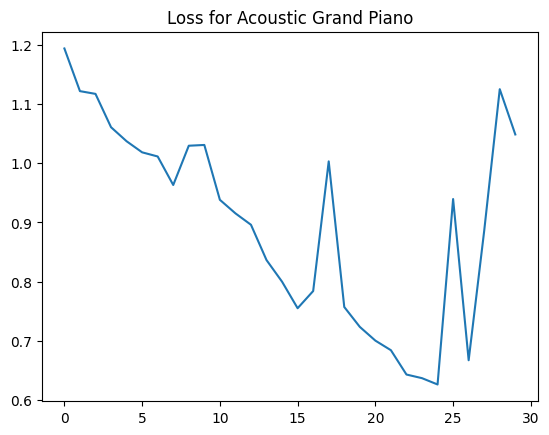

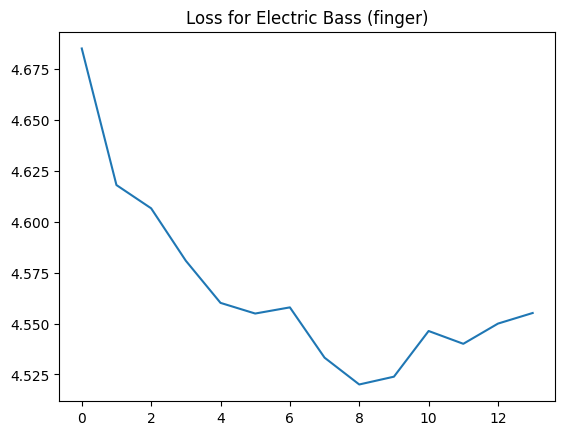

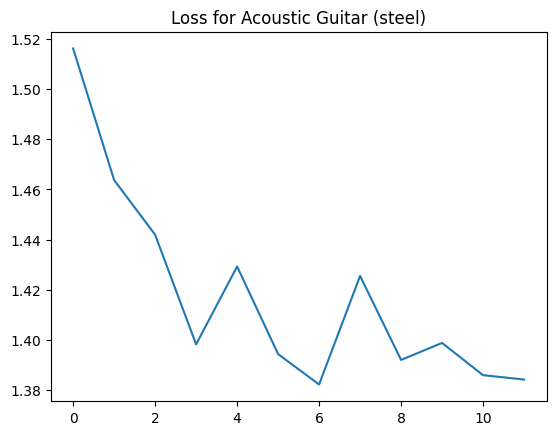

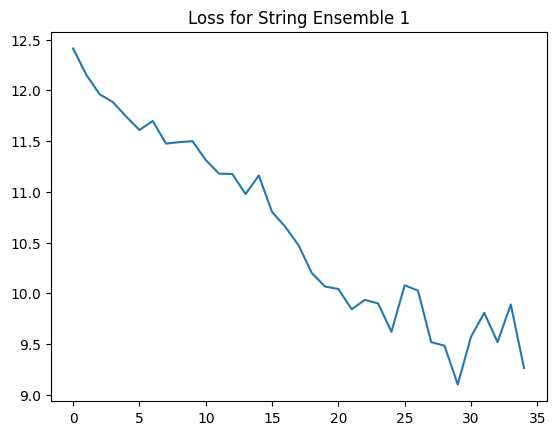

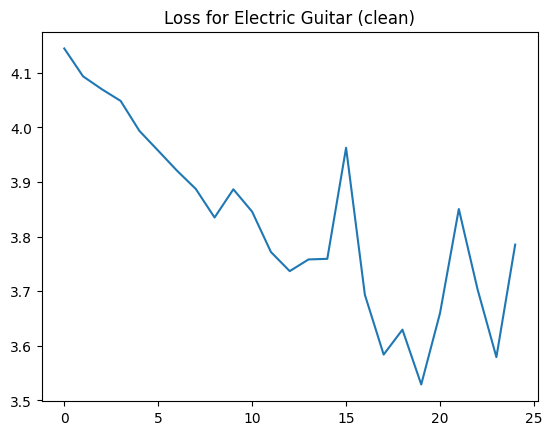

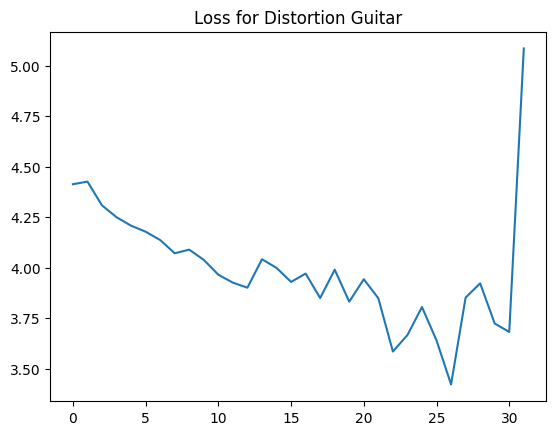

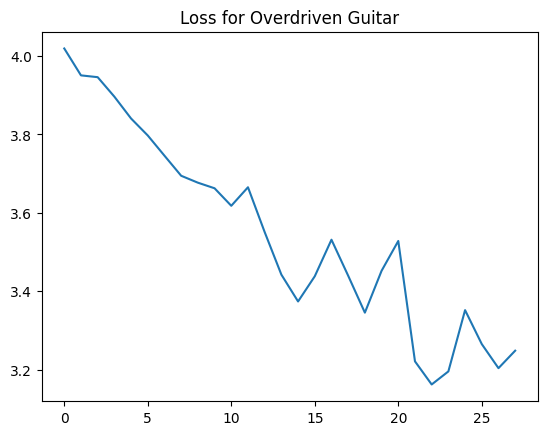

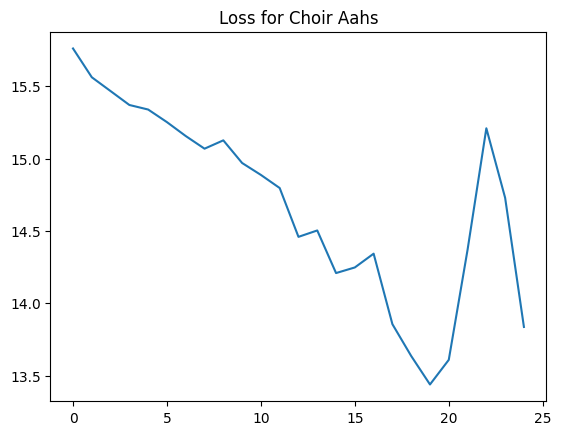

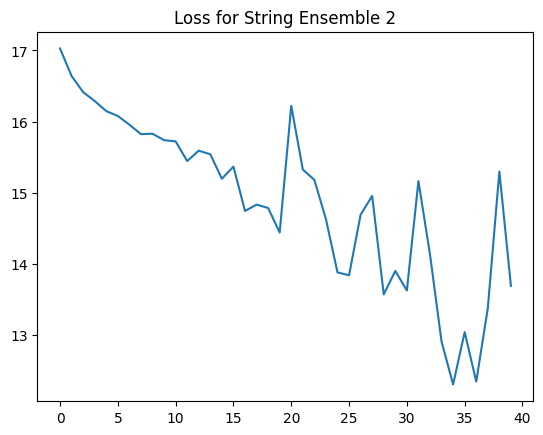

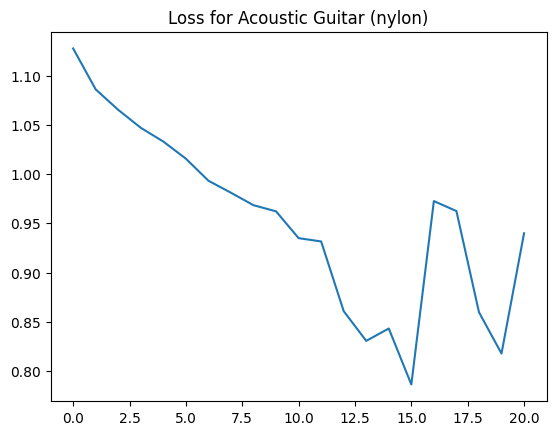

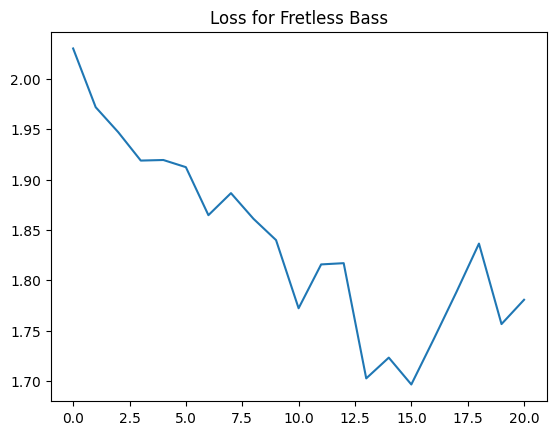

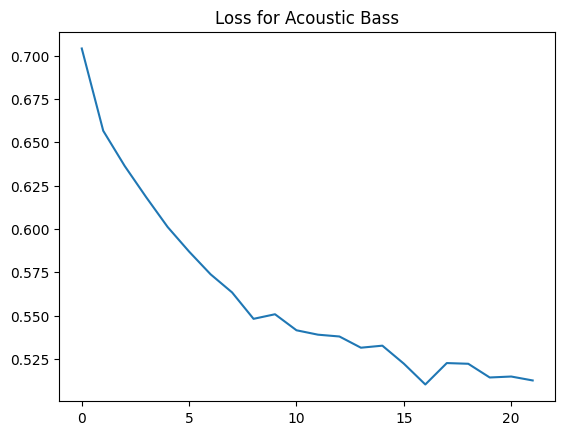

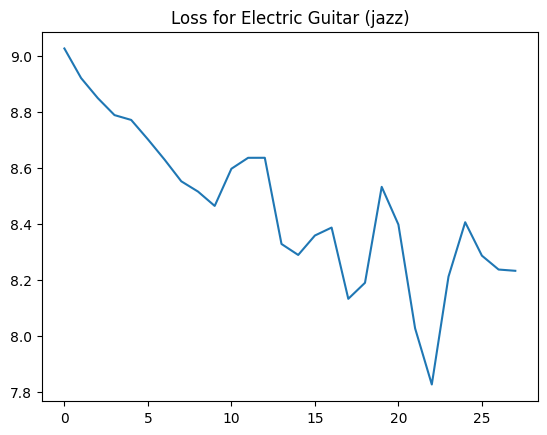

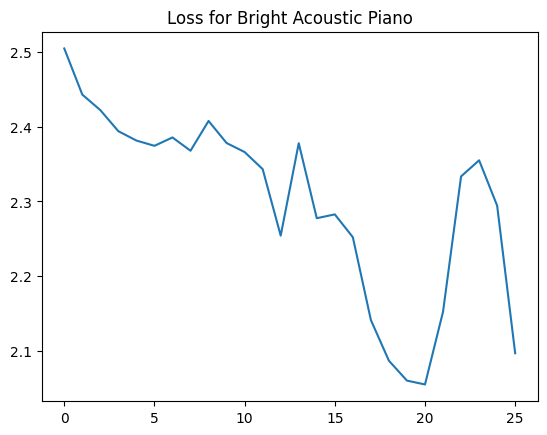

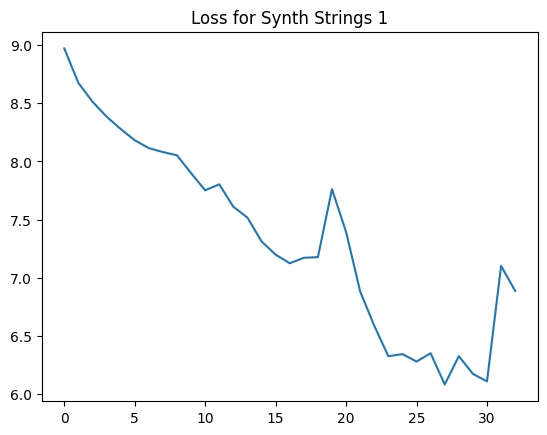

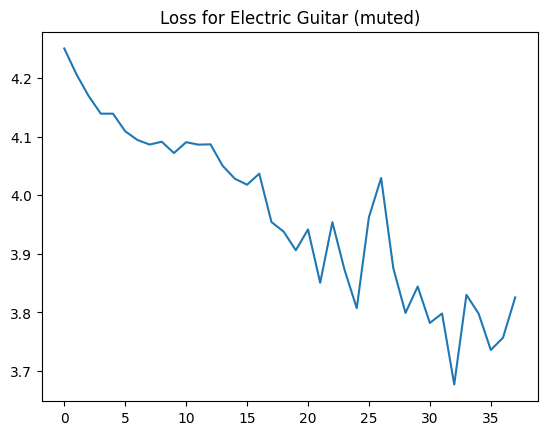

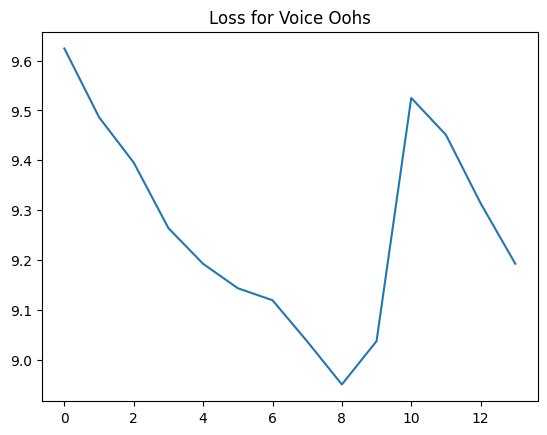

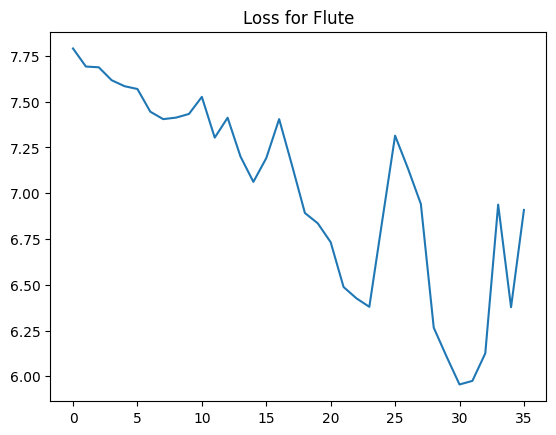

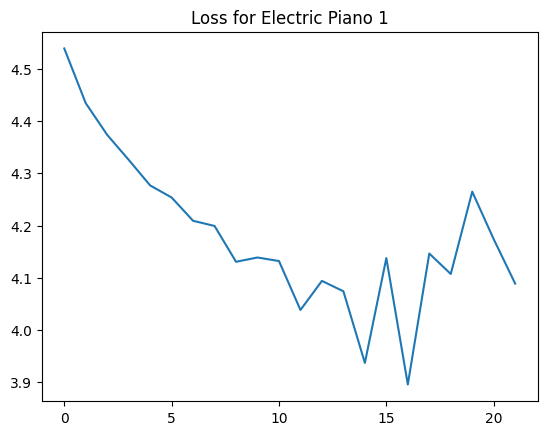

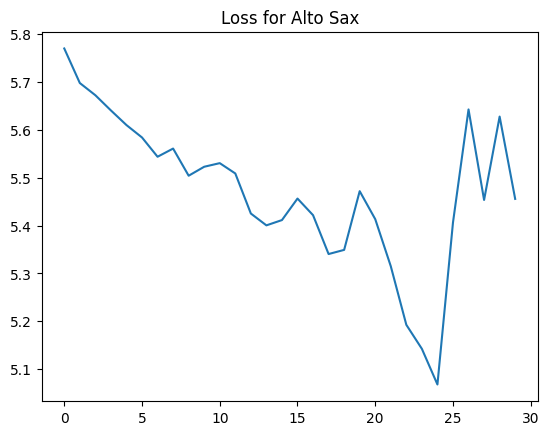

In [89]:
for instru in top_instru.index:
    
    plt.plot(hist_data[instru].epoch, hist_data[instru].history['loss'], label='total loss')
    plt.title("Loss for " + instru)
    plt.show()

In [75]:
# %%time
# test_hist, test_mod = make_train_model(train_ds)

780/780 [==============================] - 4s 5ms/step - loss: 1.6270 - duration_loss: 0.2743 - pitch_loss: 4.8497 - step_loss: 0.8677
Epoch 1/50
780/780 [==============================] - 9s 10ms/step - loss: 1.1991 - duration_loss: 0.0927 - pitch_loss: 3.0229 - step_loss: 0.8042
Epoch 2/50
780/780 [==============================] - 8s 10ms/step - loss: 1.1205 - duration_loss: 0.0837 - pitch_loss: 2.5434 - step_loss: 0.7825
Epoch 3/50
780/780 [==============================] - 8s 10ms/step - loss: 1.0928 - duration_loss: 0.0817 - pitch_loss: 2.4388 - step_loss: 0.7672
Epoch 4/50
780/780 [==============================] - 7s 9ms/step - loss: 1.0818 - duration_loss: 0.0805 - pitch_loss: 2.4271 - step_loss: 0.7586
Epoch 5/50
780/780 [==============================] - 8s 10ms/step - loss: 1.0872 - duration_loss: 0.0802 - pitch_loss: 2.4801 - step_loss: 0.7590
Epoch 6/50
780/780 [==============================] - 7s 9ms/step - loss: 1.0506 - duration_loss: 0.0759 - pitch_loss: 2.3966 - ste

In [60]:
# %%time
# epochs = 50

# history = model.fit(train_ds, epochs=epochs, callbacks=callbacks,)

Epoch 1/50
780/780 [==============================] - 8s 9ms/step - loss: 1.2038 - duration_loss: 0.0933 - pitch_loss: 3.0697 - step_loss: 0.8035
Epoch 2/50
780/780 [==============================] - 7s 9ms/step - loss: 1.1287 - duration_loss: 0.0841 - pitch_loss: 2.6051 - step_loss: 0.7841
Epoch 3/50
780/780 [==============================] - 7s 9ms/step - loss: 1.1072 - duration_loss: 0.0825 - pitch_loss: 2.5528 - step_loss: 0.7694
Epoch 4/50
780/780 [==============================] - 8s 10ms/step - loss: 1.0861 - duration_loss: 0.0805 - pitch_loss: 2.4821 - step_loss: 0.7574
Epoch 5/50
780/780 [==============================] - 7s 9ms/step - loss: 1.0663 - duration_loss: 0.0787 - pitch_loss: 2.3508 - step_loss: 0.7525
Epoch 6/50
780/780 [==============================] - 7s 9ms/step - loss: 1.0542 - duration_loss: 0.0773 - pitch_loss: 2.4394 - step_loss: 0.7330
Epoch 7/50
780/780 [==============================] - 7s 9ms/step - loss: 1.0345 - duration_loss: 0.0736 - pitch_loss: 2.46

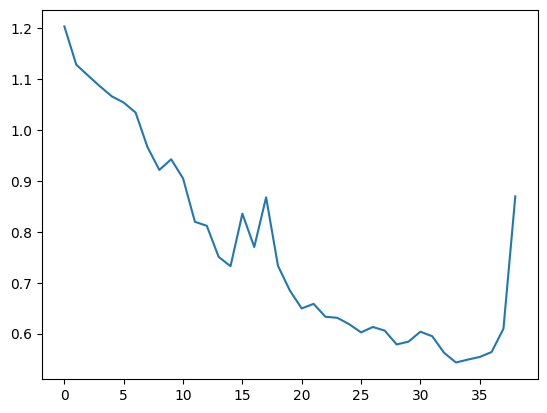

In [61]:
# plt.plot(history.epoch, history.history['loss'], label='total loss')
# plt.show()

In [91]:
# 예측을 하려면 노트의 시퀀스를 넣어야함.
# 노트의 시퀀스를 만들어서 넣기.
# 노트 피치는 소프트맥스 함수로 나눠진거에서 샘플로 여러개를 가지고 오고 제일 높은 확률만 가져오지 않음

def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0 #온도가 노트들 랜덤생성하게 하는거 도와주는 펑션

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative. if change to 0, sometimes too many 0s.
  if step < 0:
    step = step * -1
  if duration < 0:
    duration = duration * -1
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [63]:
# #이런 노래를 넣어서 해보기
# raw_notes = midi_to_notes(filenames[0], top_instru.index[0])

In [86]:
# raw_notes

,pitch,start,end,step,duration
0,35,3.116884,4.038962,0.000000,0.922078
1,35,4.512988,4.655845,1.396104,0.142857
2,35,4.675326,4.948053,0.162338,0.272727
3,35,5.064936,5.487015,0.389610,0.422078
4,35,5.844157,6.019482,0.779221,0.175325
...,...,...,...,...,...
273,35,225.974090,226.311752,0.162338,0.337662
274,35,226.363700,226.753311,0.389611,0.389611
275,35,227.142921,227.305259,0.779221,0.162338
276,35,227.532532,228.045865,0.389611,0.513333


In [92]:
def get_generated_notes(
        notes: np.ndarray,
        keras_model: tf.keras.Model,
        temperature: float = 2.0,
        num_predictions: int = 120
):

    sample_notes = np.stack([notes[key] for key in key_order], axis=1)
    input_notes = (
        sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

    generated_notes = []
    prev_start = 0
    for _ in range(num_predictions):
        pitch, step, duration = predict_next_note(input_notes, keras_model, temperature)
        start = prev_start + step
        end = start + duration
        input_note = (pitch, step, duration)
        generated_notes.append((*input_note, start, end))
        input_notes = np.delete(input_notes, 0, axis=0)
        input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
        prev_start = start

    generated_notes = pd.DataFrame(
        generated_notes, columns=(*key_order, 'start', 'end'))
    
    return generated_notes

In [64]:
# #온도, 시작 시퀀스 가지고 바꿔보기.
# temperature = 2.0
# num_predictions = 120

# sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# # The initial sequence of notes; pitch is normalized similar to training sequences
# input_notes = (
#     sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

# generated_notes = []
# prev_start = 0
# for _ in range(num_predictions):
#   pitch, step, duration = predict_next_note(input_notes, model, temperature)
#   start = prev_start + step
#   end = start + duration
#   input_note = (pitch, step, duration)
#   generated_notes.append((*input_note, start, end))
#   input_notes = np.delete(input_notes, 0, axis=0)
#   input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
#   prev_start = start

# generated_notes = pd.DataFrame(
#     generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 11ms/step


In [115]:
gen_notes_dict = {}

for instrument_name, notes_df in random_notes.items():
    gen_note = get_generated_notes(notes_df, mod_data[instrument_name], 2, 120)
    gen_notes_dict[instrument_name] = gen_note

out_file = 'sample/mixture1.mid'
out_pm = dict_to_midi(gen_notes_dict, out_file)
display_audio(out_pm)

1/1 [==============================] - 0s 12ms/step


In [65]:
# sample_notes


array([[3.50000000e+01, 0.00000000e+00, 9.22078183e-01],
       [3.50000000e+01, 1.39610429e+00, 1.42857183e-01],
       [3.50000000e+01, 1.62337708e-01, 2.72727350e-01],
       [3.50000000e+01, 3.89610500e-01, 4.22078042e-01],
       [3.50000000e+01, 7.79221000e-01, 1.75324725e-01],
       [3.50000000e+01, 3.89610500e-01, 7.46753458e-01],
       [3.50000000e+01, 1.39610429e+00, 1.42857183e-01],
       [3.50000000e+01, 1.62337708e-01, 2.59740333e-01],
       [3.50000000e+01, 3.89610500e-01, 3.89610500e-01],
       [3.50000000e+01, 7.79221000e-01, 1.62337708e-01],
       [3.50000000e+01, 3.89610500e-01, 7.14285917e-01],
       [3.50000000e+01, 1.39610429e+00, 1.42857183e-01],
       [3.50000000e+01, 1.62337708e-01, 3.24675417e-01],
       [3.50000000e+01, 3.89610500e-01, 4.22078042e-01],
       [3.50000000e+01, 7.79221000e-01, 1.75324725e-01],
       [3.50000000e+01, 3.89610500e-01, 1.07142887e+00],
       [3.50000000e+01, 1.55844200e+00, 2.93506577e+00],
       [3.50000000e+01, 3.11688

In [77]:
# test_gen = get_generated_notes(raw_notes, test_mod, 2, 120)

1/1 [==============================] - 0s 11ms/step


In [78]:
test_gen

,pitch,step,duration,start,end
0,36,0.315888,0.446833,0.315888,0.762721
1,76,1.354446,0.909643,1.670334,2.579977
2,72,2.290719,0.685508,3.961053,4.646561
3,71,3.109363,0.669243,7.070416,7.739659
4,72,3.886726,0.651490,10.957142,11.608632
...,...,...,...,...,...
115,72,2.496030,0.543335,302.977094,303.520429
116,72,2.487879,0.542991,305.464973,306.007963
117,72,2.487704,0.543225,307.952677,308.495901
118,72,2.488159,0.543261,310.440835,310.984096


In [66]:
# generated_notes

,pitch,step,duration,start,end
0,35,0.315888,0.446833,0.315888,0.762721
1,71,1.281675,0.918603,1.597563,2.516166
2,76,2.332558,0.691391,3.930121,4.621512
3,72,2.846358,0.664862,6.776479,7.441341
4,72,3.801365,0.654365,10.577844,11.232209
...,...,...,...,...,...
115,72,2.483311,0.541984,300.110587,300.652571
116,72,2.514935,0.544019,302.625522,303.169541
117,72,2.506192,0.542400,305.131715,305.674115
118,72,2.503687,0.542610,307.635401,308.178012


In [79]:
out_file = 'sample/output6.mid'
out_pm = notes_to_midi(
    test_gen, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [68]:
# 악곡은 노트의 연속성이니 시각화 해보기. 첫번쨰 instrument 가 피아노니까 트랙 길이에 음표, 피치, 시작 & 끝을 플롯해보기.
# count 는 input 에 있거나 없거나 상관없음. 
def plot_notes_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [48]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

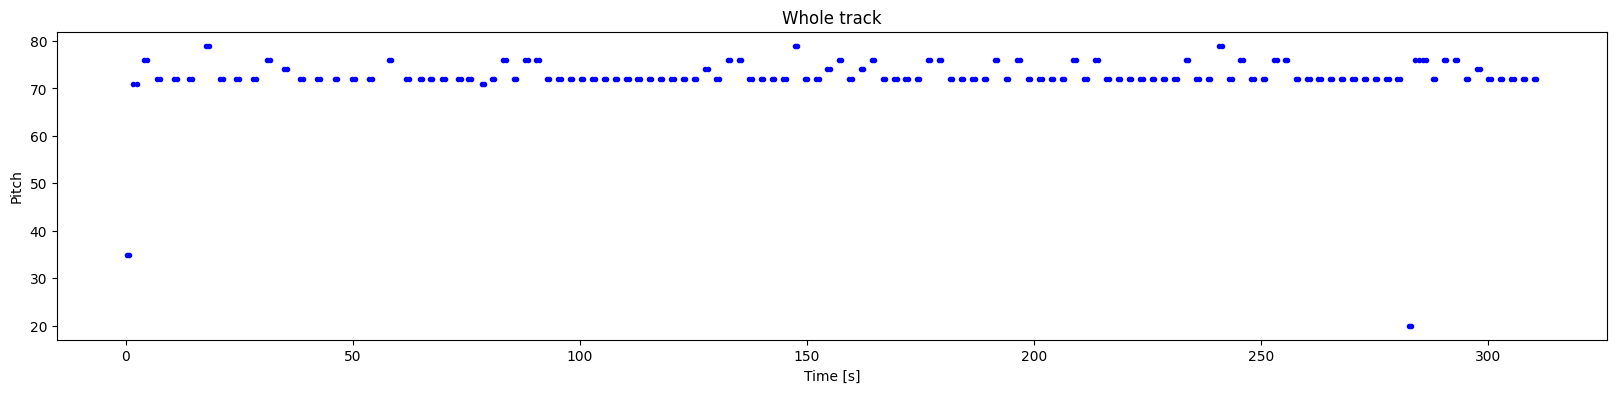

In [69]:
plot_notes_roll(generated_notes)

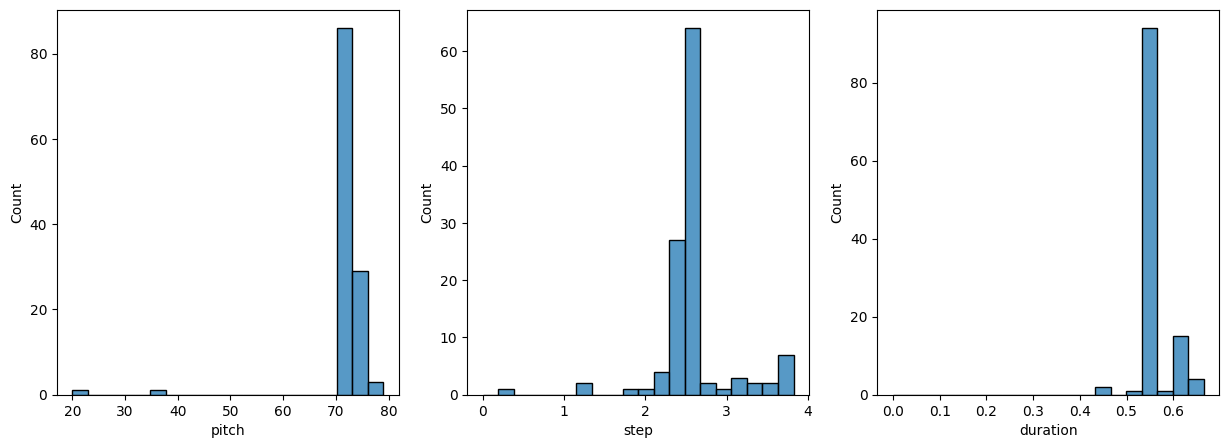

In [70]:
plot_distributions(generated_notes)